In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import re

# --- Function to extract numeric part from filenames ---
def numeric_sort_key(filename):
    # Use regular expression to extract numeric part from filename (this assumes filenames contain numbers)
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0  # Default to 0 if no number is found

# --- Load the data ---

# Paths to the dataset
train_data_path = '/kaggle/input/final-augmented-dataset/aug-and-images-20240918T063356Z-001/aug-and-images'
train_mask_data_path = '/kaggle/input/final-augmented-dataset/aug-and-masks-20240918T063354Z-001/aug-and-masks'

# Load images and masks (limit to 100 for demonstration)
training_images = sorted(os.listdir(train_data_path),key=numeric_sort_key )[0:1328]
training_masks = sorted(os.listdir(train_mask_data_path),key=numeric_sort_key )[0:1328]

# Image dimensions
row, columns = 512, 512

# Initialize arrays for images and masks
x_train = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)
y_train = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)

# Load and resize images and masks
for index, name in enumerate(training_images):
    img_path = os.path.join(train_data_path, name)
    mask_path = os.path.join(train_mask_data_path, name)
    
    if os.path.exists(mask_path):
        image = imread(img_path)
        mask = imread(mask_path)
#         mask = (mask > 0.5).astype(np.float32)
        
        # Expand mask dimensions from (512, 512) to (512, 512, 1)
#         mask = np.expand_dims(mask, axis=-1)
        
        x_train[index] = image
        y_train[index] = mask

In [3]:
x_train = x_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0
# y_train = y_train.astype(np.float32)
y_train = (y_train > .1).astype(np.float32)

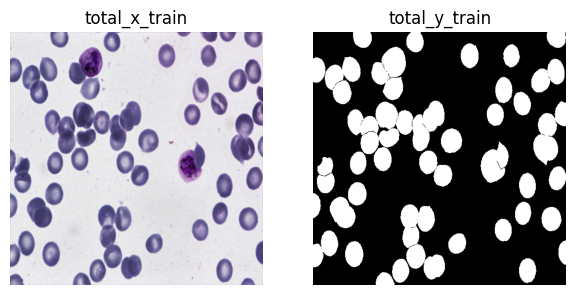

In [4]:
import matplotlib.pyplot as plt

# Plot the first image from x_train
plt.figure(figsize=(15, 5))  # Set figure size to display all images properly
index=12
plt.subplot(1, 4, 1)  # (1 row, 3 columns, first subplot)
plt.imshow(x_train[index])
plt.title('total_x_train')
plt.axis('off')  # Hide axes

# Plot the first image from augmented_masks
plt.subplot(1, 4, 2)  # (1 row, 3 columns, third subplot)
plt.imshow(y_train[index])
plt.title('total_y_train')
plt.axis('off')

# Display the images
plt.show()

In [5]:
import tensorflow.keras.backend as K

def dice_coef(a, b):

    hi = a
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a 
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def termina_net(input_shape=(512, 512, 3)):  # Change input shape to (512, 512, 3)
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)  # Output layer for binary segmentation

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# # Create the model
# input_shape = (512, 512, 3)  # Update to RGB input
# model = termina_net(input_shape)

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Model summary
# model.summary()


In [7]:
# # Create the model
input_shape = (512, 512, 3)  # Update to RGB input
model = termina_net(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=[dice_coef, jaccard_index])

# Model summary
model.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 7,760,163 (29.60 MB)

 Trainable params: 7,760,163 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
#earlystopper,
history = model.fit(x_train[10:], y_train[10:], validation_split=0.2, batch_size=1, epochs=20,callbacks=[earlystopper, checkpoint])

Epoch 1/20


I0000 00:00:1727719406.045020      97 service.cc:145] XLA service 0x7e2da000ae90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727719406.045112      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/1054 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - dice_coef: 0.1873 - jaccard_index: 0.1240 - loss: 0.6991           

I0000 00:00:1727719414.285523      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dice_coef: 0.6205 - jaccard_index: 0.5125 - loss: 0.2937
Epoch 1: val_loss improved from inf to 0.10520, saving model to model.keras
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 66s 49ms/step - dice_coef: 0.6206 - jaccard_index: 0.5127 - loss: 0.2936 - val_dice_coef: 0.8226 - val_jaccard_index: 0.7503 - val_loss: 0.1052
Epoch 2/20
1053/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dice_coef: 0.7968 - jaccard_index: 0.7134 - loss: 0.1284
Epoch 2: val_loss improved from 0.10520 to 0.09172, saving model to model.keras
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - dice_coef: 0.7968 - jaccard_index: 0.7134 - loss: 0.1283 - val_dice_coef: 0.8317 - val_jaccard_index: 0.7646 - val_loss: 0.0917
Epoch 3/20
1053/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dice_coef: 0.8040 - jaccard_index: 0.7272 - loss: 0.1156
Epoch 3: val_loss improved from 0.09172 to 0.06278, saving model to model.keras
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - dice_coef: 0.8040 - jaccard_index: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


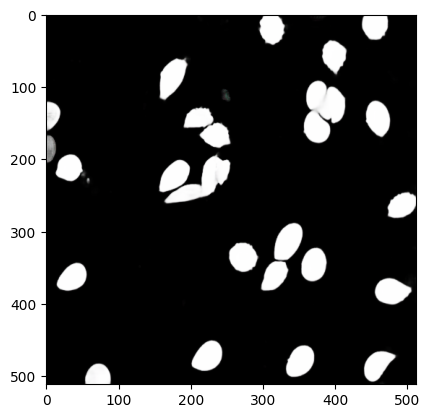

In [9]:
pred = model.predict(x_train[2:3])
pred = np.squeeze(pred)
plt.imshow(pred, cmap='gray')
plt.show()

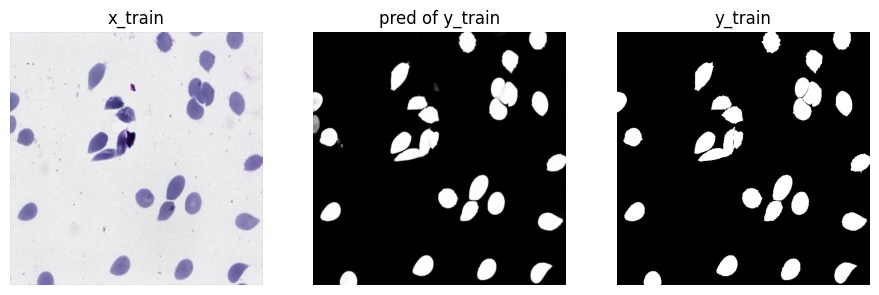

In [10]:
# Plot the first image from x_train
plt.figure(figsize=(15, 5))  # Set figure size to display all images properly
index=8
plt.subplot(1, 4, 1)  # (1 row, 3 columns, first subplot)
plt.imshow(np.squeeze(x_train[2:3]))
plt.title('x_train')
plt.axis('off')  # Hide axes

# Plot the first image from augmented_masks
plt.subplot(1, 4, 2)  # (1 row, 3 columns, third subplot)
plt.imshow(pred)
plt.title('pred of y_train')
plt.axis('off')

# Plot the first image from augmented_masks
plt.subplot(1, 4, 3)  # (1 row, 3 columns, third subplot)
plt.imshow(np.squeeze(y_train[2:3]))
plt.title('y_train')
plt.axis('off')

# Display the images
plt.show()

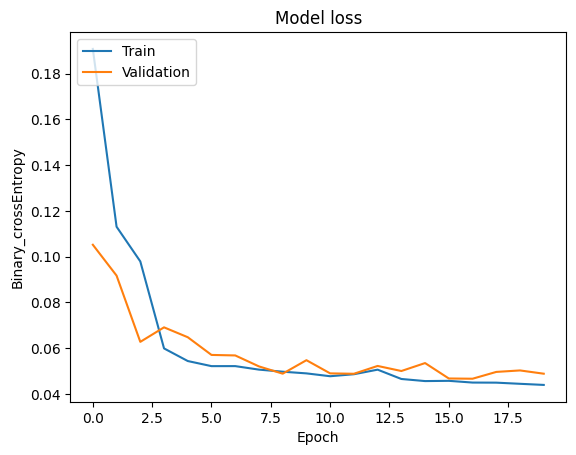

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

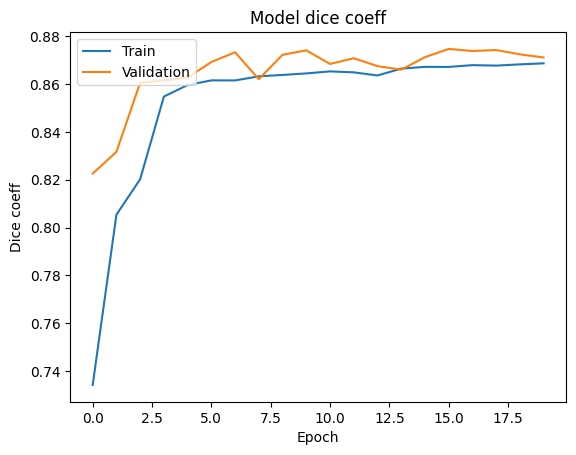

In [12]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

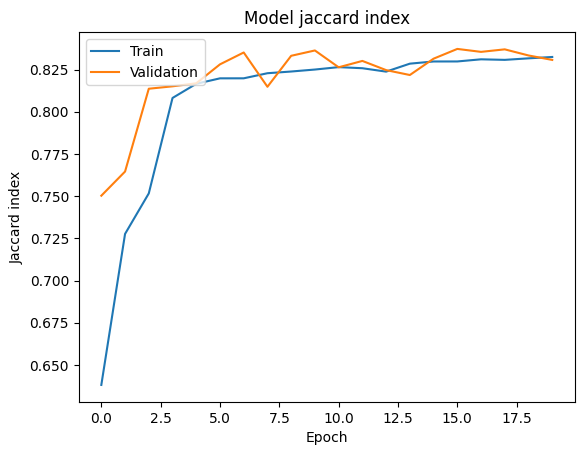

In [13]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()